# Design of a Symmetric Broadband Splitter

Many devices of interest can leverage some form of simulation symmetry to reduce the computational cost and storage requirements. The adjoint solver and its corresponding TO filter toolbox are built to work with these symmetries.

To demonstrate this, we look at a symmetric, broadband splitter.

In [1]:
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import nlopt
seed = 240
np.random.seed(seed)
mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

Using MPI version 3.1, 1 processes


/usr/local/lib/python3.9/site-packages/meep/simulation.py:5441: RuntimeWarning: quiet has been deprecated; use the Verbosity class instead
  warnings.warn("quiet has been deprecated; use the Verbosity class instead", RuntimeWarning)


As before, we'll define our geometry, filtering, and wavelength parameters.

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5
arm_separation = 1.0
waveguide_length = 0.5
pml_size = 1.0
resolution = 20

minimum_length = 0.09
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(5*resolution)

frequencies = 1/np.linspace(1.5,1.6,10)
#print(1/frequencies)

We'll also define our simulation domain and set up a broadband source.

In [3]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width
Sy = 2*pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.56
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

Next, we'll define our design region. This time, however, we'll include a symmetry across the Y plane (normal direction of the symmetry plane points in the Y direction).

In [4]:
Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_MEAN')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0)))

We'll define a filtering and interpolation function. We need to include the symmetry requirements in the filter too.

In [5]:
def mapping(x,eta,beta):
    
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    projected_field = (npa.fliplr(projected_field) + projected_field)/2 # up-down symmetry
    
    # interpolate to actual materials
    return projected_field.flatten()

We also need to define a bitmask that describes the boundary conditions of the waveguide and cladding layers.

In [6]:
# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width/2,design_region_width/2,Nx)
y_g = np.linspace(-design_region_height/2,design_region_height/2,Ny)
X_g, Y_g = np.meshgrid(x_g,y_g,sparse=True,indexing='ij')

# Define the core mask
left_wg_mask = (X_g == -design_region_width/2) & (np.abs(Y_g) <= waveguide_width/2)
top_right_wg_mask = (X_g == design_region_width/2) & (np.abs(Y_g + arm_separation/2) <= waveguide_width/2)
bottom_right_wg_mask = (X_g == design_region_width/2) & (np.abs(Y_g - arm_separation/2) <= waveguide_width/2)
Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

# Define the cladding mask
border_mask = ((X_g == -design_region_width/2)  | 
               (X_g ==  design_region_width/2)  | 
               (Y_g == -design_region_height/2) | 
               (Y_g ==  design_region_height/2))
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

Finally we can formulate our geometry and simulation object.

In [7]:
geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables),
    #mp.Block(center=design_region.center, size=design_region.size, material=design_variables, e2=mp.Vector3(y=-1))
    # 
    # The commented line above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; instead, we use an alternative approach to impose symmetry.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

We can proceed to define our objective function, its corresponding arguments, and the optimization object.

In [8]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,arm_separation/2,0),size=mp.Vector3(y=arm_separation)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,-arm_separation/2,0),size=mp.Vector3(y=arm_separation)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(source,top,bottom):
    power = npa.abs(top/source) ** 2 + npa.abs(bottom/source) ** 2
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies,
    decay_by = 1e-8,
)

Let's plot the design and ensure we have symmetry.

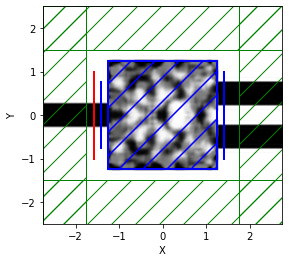

In [9]:
plt.figure()
x0 = mapping(np.random.rand(Nx*Ny,),eta_i,128)
opt.update_design([x0])
opt.plot2D(True)
plt.show()

We'll define a simple objective function that returns the gradient. We'll plot the new geometry after each iteration.

In [10]:
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)])
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    circ = Circle((2,2),minimum_length/2)
    ax.add_patch(circ)
    ax.axis('off')
    plt.show()
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,np.sum(dJ_du,axis=1))
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

Finally we'll run the optimizer.

current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


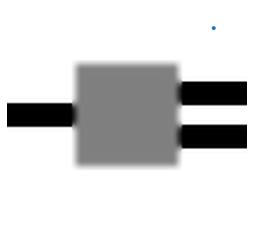

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


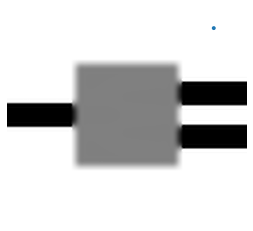

current beta:  8
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


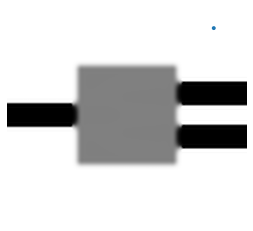

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


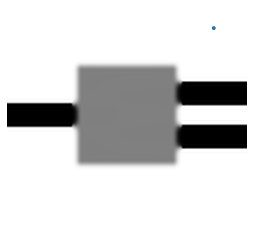

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


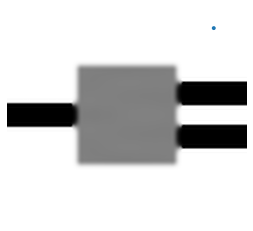

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


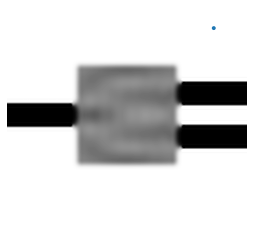

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


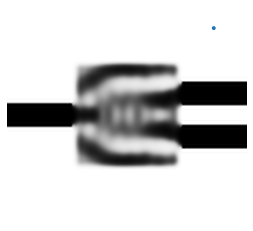

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


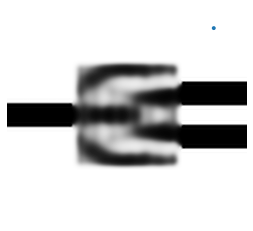

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


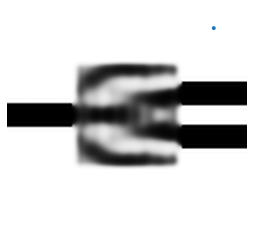

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


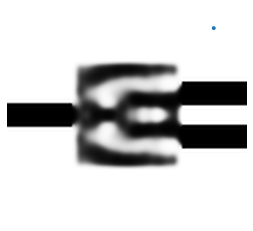

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


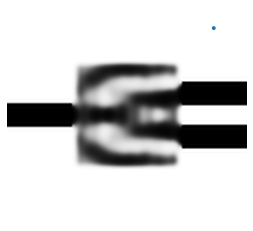

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


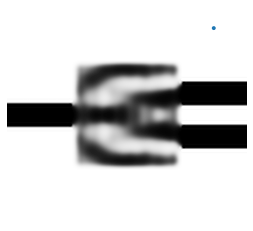

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


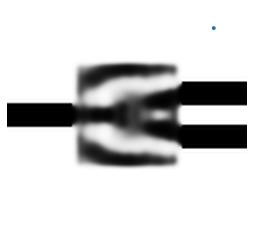

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


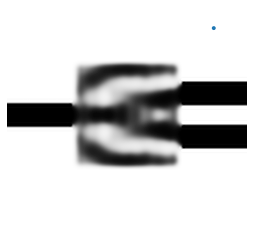

current beta:  16
Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


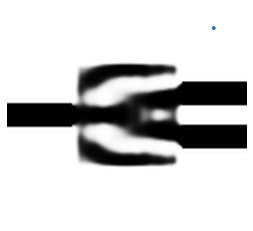

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


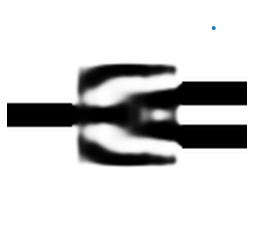

current beta:  32
Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


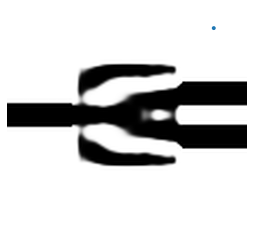

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


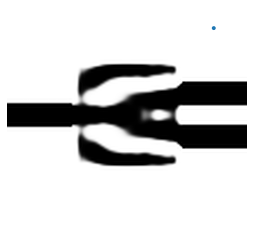

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


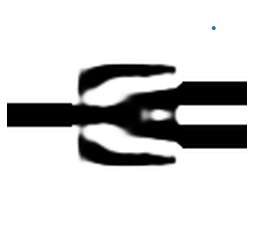

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


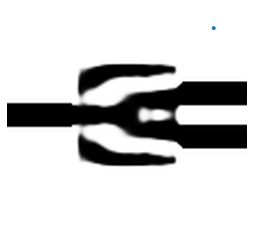

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


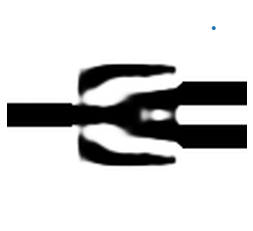

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


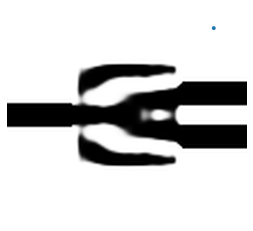

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


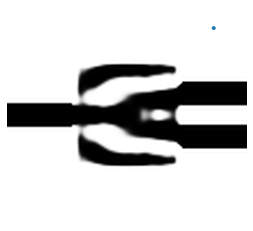

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


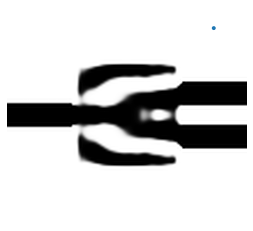

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


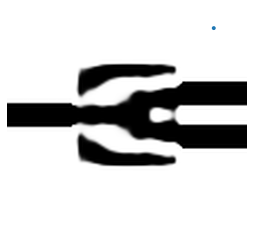

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


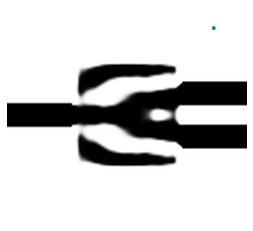

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


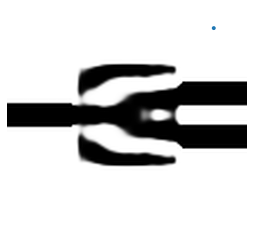

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


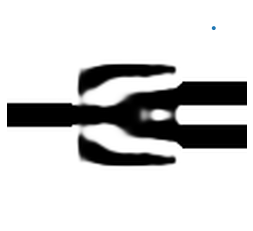

current beta:  64
Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


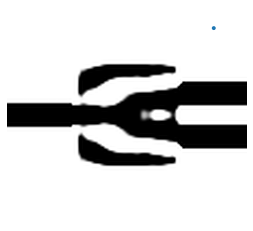

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


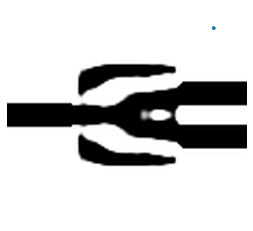

current beta:  128
Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


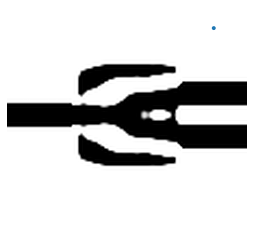

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


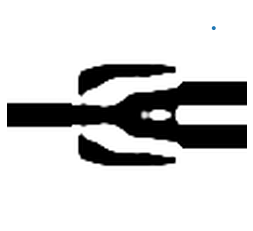

In [11]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1 # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0 # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx*Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx*Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    print("current beta: ",cur_beta)
    
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_xtol_rel(1e-4)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

We can see that the optimizer quickly finds a topology that works well and slowly refines it as we continue to "binarize" the design.

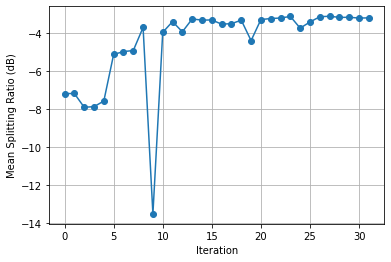

In [12]:
plt.figure()
plt.plot(10*np.log10(0.5*np.array(evaluation_history)),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Mean Splitting Ratio (dB)')
plt.show()

We can view the final spectral response to verify that the design performs.

In [13]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

Starting forward run...


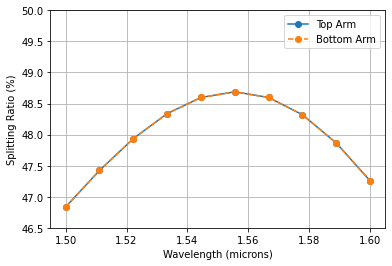

In [14]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Splitting Ratio (%)')
plt.ylim(46.5,50)
plt.show()

And of course we'll visualize the final topology. We'll plot the minimum length scale as a circle in the upper corner.

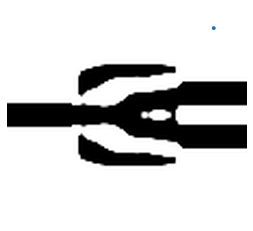

In [15]:
opt.update_design([mapping(x,eta_i,cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
circ = Circle((2,2),minimum_length/2)
ax.add_patch(circ)
ax.axis('off')
plt.show()